In [5]:
# Load necessary library
import pandas as pd
import numpy as np
from surprise import SVD, BaselineOnly, Dataset, Reader
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1.Exploratory Data Analysis

In [6]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# check rating distribution
print(train_df['rating'].value_counts().sort_index())

rating
1     29149
2     35446
3     79870
4    185193
5    416231
Name: count, dtype: int64


In [7]:
# === Train Set Overview ===
print("=== Train Set Overview ===")
print(train_df.info())
print(train_df.describe(include='all'))

# === Test Set Overview ===
print("\n=== Test Set Overview ===")
print(test_df.info())
print(test_df.describe(include='all'))

# === Rating distribution ===
print("\n=== Training Rating Distribution ===")
print(train_df['rating'].value_counts().sort_index())

# === ID Ranges ===
print("\n=== ID Ranges ===")
print("Train - User ID range:", train_df['user_id'].min(), "to", train_df['user_id'].max())
print("Train - Product ID range:", train_df['product_id'].min(), "to", train_df['product_id'].max())
print("Test  - User ID range:", test_df['user_id'].min(), "to", test_df['user_id'].max())
print("Test  - Product ID range:", test_df['product_id'].min(), "to", test_df['product_id'].max())

# === Top Active Users ===
print("\n=== Top Active Users ===")
print(train_df['user_id'].value_counts().head())

# === Top Reviewed Products ===
print("\n=== Top Reviewed Products ===")
print(train_df['product_id'].value_counts().head())

# === Check duplicate user-product pairs ===
duplicates = train_df.duplicated(subset=['user_id', 'product_id']).sum()
print(f"\n=== Duplicate User-Product Pairs in Train Set: {duplicates} ===")

# === Cold-start check ===
train_users = set(train_df['user_id'])
train_products = set(train_df['product_id'])
test_users = set(test_df['user_id'])
test_products = set(test_df['product_id'])

cold_users = test_users - train_users
cold_products = test_products - train_products

print("\n=== Cold-Start Analysis ===")
print("Cold-start users in test set:", len(cold_users))
print("Cold-start products in test set:", len(cold_products))

=== Train Set Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745889 entries, 0 to 745888
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        745889 non-null  int64 
 1   product_id     745889 non-null  int64 
 2   product_name   745889 non-null  object
 3   rating         745889 non-null  int64 
 4   votes          745889 non-null  int64 
 5   helpful_votes  745889 non-null  int64 
 6   ID             745889 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 39.8+ MB
None
              user_id     product_id product_name         rating  \
count   745889.000000  745889.000000       745889  745889.000000   
unique            NaN            NaN       178037            NaN   
top               NaN            NaN   The Hobbit            NaN   
freq              NaN            NaN          783            NaN   
mean      1143.427653  116563.109093          NaN       4.238671   
std

/var/folders/qw/999v1mjj1jqf4vrtqy31cwv80000gn/T/ipykernel_26918/3985652804.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=train_df, palette='Blues')


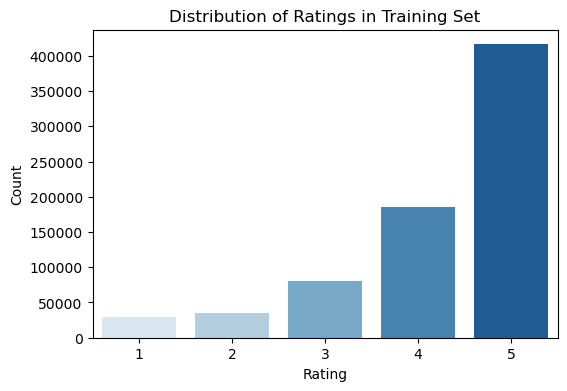

In [8]:
# Rating Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=train_df, palette='Blues')
plt.title("Distribution of Ratings in Training Set")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# 2. Feature Engineering

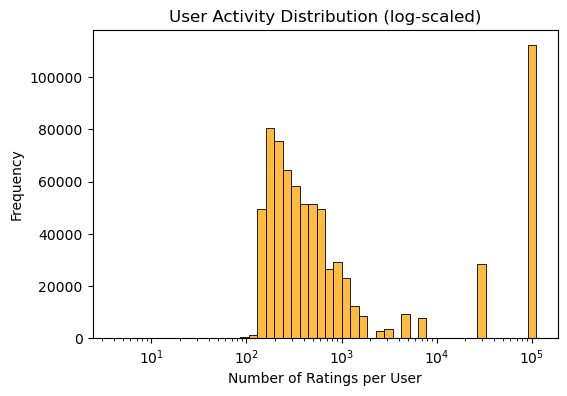

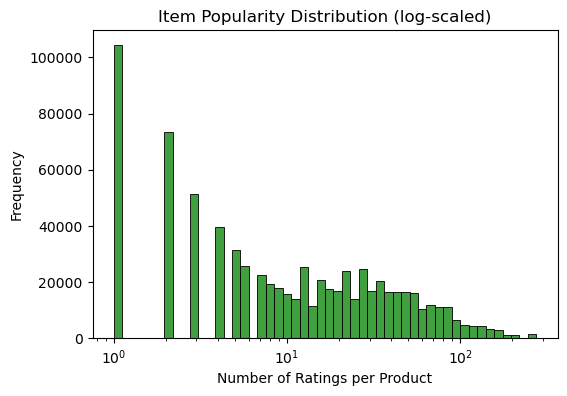

In [9]:
# Add structured features
user_counts = train_df['user_id'].value_counts().to_dict()
item_counts = train_df['product_id'].value_counts().to_dict()

train_df['user_count'] = train_df['user_id'].map(user_counts)
train_df['item_count'] = train_df['product_id'].map(item_counts)
test_df['user_count'] = test_df['user_id'].map(user_counts).fillna(0)
test_df['item_count'] = test_df['product_id'].map(item_counts).fillna(0)

# User Count Histogram
plt.figure(figsize=(6, 4))
sns.histplot(train_df['user_count'], bins=50, log_scale=True, color='orange')
plt.title("User Activity Distribution (log-scaled)")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.show()

# Item Count Histogram
plt.figure(figsize=(6, 4))
sns.histplot(train_df['item_count'], bins=50, log_scale=True, color='green')
plt.title("Item Popularity Distribution (log-scaled)")
plt.xlabel("Number of Ratings per Product")
plt.ylabel("Frequency")
plt.show()

# 3. Model Training and Validation

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_all, y_all = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\n=== Fold {fold+1} ===")
    train_data = train_df.iloc[train_idx]
    val_data = train_df.iloc[val_idx]

    reader = Reader(rating_scale=(1, 5))
    trainset = Dataset.load_from_df(train_data[['user_id', 'product_id', 'rating']], reader).build_full_trainset()
    val_records = val_data[['user_id', 'product_id', 'rating', 'user_count', 'item_count']].to_records(index=False)

    svd_model = SVD(n_factors=170, lr_all=0.015, reg_all=0.06, n_epochs=35, random_state=42)
    baseline_model = BaselineOnly()
    svd_model.fit(trainset)
    baseline_model.fit(trainset)

    X_val, y_val, preds_val = [], [], []

    for uid, iid, true_r, u_cnt, i_cnt in val_records:
        svd_pred = svd_model.predict(uid, iid).est
        base_pred = baseline_model.predict(uid, iid).est
        X_val.append([svd_pred, base_pred, int(uid), int(iid), u_cnt, i_cnt])
        y_val.append(true_r)
        preds_val.append((svd_pred + base_pred) / 2)  # Optional: averaged prediction just for display

        # Final training set
        X_all.append([svd_pred, base_pred, int(uid), int(iid), u_cnt, i_cnt])
        y_all.append(true_r)

    # Calculate fold RMSE using average prediction (for inspection only)
    rmse = mean_squared_error(y_val, preds_val, squared=False)
    print(f"Fold {fold+1} RMSE (avg of SVD & Baseline): {rmse:.5f}")

# Train meta-model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=0.0,
    random_state=42
)
xgb_model.fit(X_all, y_all)

# Evaluate overall training RMSE
y_pred_all = xgb_model.predict(X_all)
overall_rmse = mean_squared_error(y_all, y_pred_all, squared=False)
print(f"\n Overall Training RMSE (XGBoost on all folds): {overall_rmse:.5f}")


=== Fold 1 ===
Estimating biases using als...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 RMSE (avg of SVD & Baseline): 0.91174

=== Fold 2 ===
Estimating biases using als...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 RMSE (avg of SVD & Baseline): 0.90639

=== Fold 3 ===
Estimating biases using als...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 RMSE (avg of SVD & Baseline): 0.90784

=== Fold 4 ===
Estimating biases using als...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 RMSE (avg of SVD & Baseline): 0.91353

=== Fold 5 ===
Estimating biases using als...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 RMSE (avg of SVD & Baseline): 0.90773

 Overall Training RMSE (XGBoost on all folds): 0.87077


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 4. Full Model Retraining & Prediction

In [ ]:
# Retrain base models on full data
reader = Reader(rating_scale=(1, 5))
full_train = Dataset.load_from_df(train_df[['user_id', 'product_id', 'rating']], reader).build_full_trainset()
svd_model.fit(full_train)
baseline_model.fit(full_train)

# Generate test predictions
X_test = []
for _, row in test_df.iterrows():
    uid = row['user_id']
    iid = row['product_id']
    svd_pred = svd_model.predict(uid, iid).est
    base_pred = baseline_model.predict(uid, iid).est
    X_test.append([svd_pred, base_pred, uid, iid, row['user_count'], row['item_count']])

test_preds = np.clip(xgb_model.predict(X_test), 1.0, 5.0)

# Save submission
test_df['rating'] = test_preds
test_df[['ID', 'rating']].to_csv("34711783.csv", index=False)
print("Saved as 34711783.csv.csv")